In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/users/b149899/projects/binder/binder/keys/nav_opendata.json'

In [2]:
import requests
import pandas as pd
import geopandas as gpd
import json
from datetime import datetime
import time


import dataverk as dv
import altair as alt
alt.renderers.enable('notebook')
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

# Datapakke

In [3]:
readme = """
# Bedriftsundersøkelsen.

NAVs bedriftsundersøkelse ser på hvilke forventninger bedriftene har i forhold til sysselsettingsutviklingen det kommende året, om bedriftene har mislyktes i å rekruttere arbeidskraft de siste tre månedene og om dette skyldes for få kvalifiserte søkere på stillingene. På bakgrunn av disse svarene  estimeres en mangel på arbeidskraft for landet som helhet, for ulike regioner, samt enkeltnæringer og for ulike yrker.

[les mer på nav.no](https://www.nav.no/no/NAV+og+samfunn/Kunnskap/Analyser+fra+NAV/Arbeid+og+velferd/Arbeid+og+velferd/bedriftsunders%C3%B8kelsen)

"""

url = 'https://raw.githubusercontent.com/datasett/nav-examples/bedriftsundersøkelsen-kartvisning'
auth = 'paul.bencze@nav.no'

metadata = {
'readme': readme,
'store': 'gs',
'host': url,
'accessRights': 'Open',
'author': auth,
'category': 'Åpne data',
'created_by': 'paul.bencze@nav.no',
'description': 'Bedriftsundersøkelsen: Kartvisning',
'distribution': [{'format': 'datapackage','url': url}],
'format': 'datapackage',
'keywords': ['bedriftsundersøkelsen'],
'legalbasis': ['Åpne data'],
'master': 'NAV',
'pii': 'Åpne data',
'policy': [{'legal_basis': 'Offentlighetsloven','purpose': 'Åpne data'}],
'provenance': 'NAV',
'publisher': 'NAV',
'purpose': ['Åpne data'],
'spatial': 'Norge',
'theme': ['Åpne data'],
'title': 'Bedriftsundersøkelsen: Kartvisning',
'type': 'datakatalog',
'url': url,
'project': 'odata', 
'user':'nav-examples',
'repo': 'https://raw.githubusercontent.com/datasett/nav-examples/bedriftsundersøkelsen-kartvisning',
'bucket': 'nav-opendata'
}

In [4]:
dp = dv.Datapackage(metadata)

# Henter data fra bedriftsundersøkelsen

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/datasett/examples/master/nav/opendata/navs-bedriftsundersokelse---ettersporsel-etter-arbeidskraft-per-fylke.csv.gz',
            sep=';', encoding='utf-8')
df.head(1)

,År,Fylkenr,Fylkenavn,Estimert mangel på arbeidskraft i antall personer,"95 % konfidens-intervall for estimert mangel , nedre grense","95 % konfidens-intervall for estimert mangel , øvre grense",Unnamed: 6
0,2015,1,Østfold,1009,653,1369,NaN


In [6]:
def getfylke(row):
    if 'Trøndelag' in row['Fylkenavn']:
        row['Fylkenr'] = 50
        row['Fylkenavn'] = 'Trøndelag' 
    return row  

df = df.apply(getfylke, axis=1)

In [7]:
df['Fylkenr'] = df['Fylkenr'].apply(lambda x: str(x).zfill(2))

In [8]:
df_g = df[['År','Fylkenr', 'Fylkenavn', 'Estimert mangel på arbeidskraft i antall personer']]\
.groupby(['År','Fylkenr', 'Fylkenavn']).sum().reset_index()

In [9]:
# feil i fylksenummer fra data.nav.no. Henter derfor inntil videre fylkenummer - navn mapping fra fil
df_fylker = pd.read_csv('https://raw.githubusercontent.com/datasett/examples/master/nav/opendata/fylker.csv',
            sep=';', encoding='utf-8', dtype={'Fylkenr': 'str'})


df_g = df_g.merge(df_fylker[['Fylkenr','Fylkenavn']], on='Fylkenavn', suffixes=['_dep',''] )

In [10]:
df_p = df_g.pivot_table(index=['Fylkenr', 'Fylkenavn'],
        values=['Estimert mangel på arbeidskraft i antall personer'],
        columns='År').reset_index()

In [11]:
columns = df_p.columns.get_level_values(1).astype(str).tolist()
columns[0] = 'Fylkenr'
columns[1] = 'Fylkenavn'
df_p.columns=columns
df_p

,Fylkenr,Fylkenavn,2015,2016,2017,2018
0,01,Østfold,1009,2175,1818,2405
1,02,Akershus,1606,2015,1731,4236
2,03,Oslo,2574,4922,7880,8512
3,04,Hedmark,669,870,629,1557
4,05,Oppland,654,714,777,1084
5,06,Buskerud,928,1351,1528,2320
6,07,Vestfold,875,967,1266,1413
7,08,Telemark,779,823,843,1179
8,09,Aust-Agder,430,334,512,1177
9,10,Vest-Agder,300,657,741,874


# Kartvisning

In [12]:
def download_json():
    url = "https://raw.githubusercontent.com/datasett/maps/master/norway/data/fylker_2019_s_geojson.json"
    resp = requests.get(url)
    return resp.json()

norway_json = download_json()



In [13]:
gdf = gpd.GeoDataFrame.from_features((norway_json))
gdf.head(1)

,area_fylke,centroid_fylke,fylke_navn_2019,fylke_nummer_2019,geometry
0,0.790077,"[11.165902547046743, 60.01680115972411]",AKERSHUS,02,"(POLYGON ((10.49931623545119 59.7877826916611,..."


In [14]:
gdf = gpd.GeoDataFrame.from_features((norway_json))
gdf = gdf.merge(df_p, left_on='fylke_nummer_2019', right_on='Fylkenr', how='inner')
gdf['lat'] = gdf['centroid_fylke'].apply(lambda x : x[1])
gdf['lon'] = gdf['centroid_fylke'].apply(lambda x : x[0])
gdf['tooltip'] = gdf['Fylkenavn']

In [15]:
gdf.head(1)

,area_fylke,centroid_fylke,fylke_navn_2019,fylke_nummer_2019,geometry,Fylkenr,Fylkenavn,2015,2016,2017,2018,lat,lon,tooltip
0,0.790077,"[11.165902547046743, 60.01680115972411]",AKERSHUS,02,"(POLYGON ((10.49931623545119 59.7877826916611,...",02,Akershus,1606,2015,1731,4236,60.016801,11.165903,Akershus


In [16]:
no_json = json.loads(gdf.to_json())
no_data = alt.Data(values=no_json['features'])

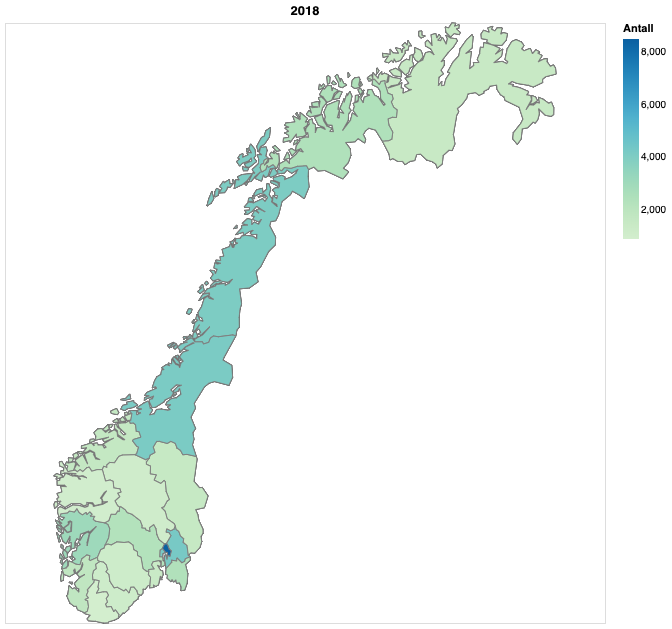

In [17]:
def gen_map(geodata, color_column, title, height=200, width=200):
    base = alt.Chart(geodata, title = title).mark_geoshape(
        stroke='black',
        strokeWidth=1
    ).encode(
    ).properties(
        width=width,
        height=height
    )
    
    choro = alt.Chart(geodata).mark_geoshape(
        stroke='gray'
    ).encode(
        alt.Color(color_column, 
                  type='quantitative', 
                  scale=alt.Scale(scheme='greenblue'),
                  title = "Antall")
    )

    return base + choro

fig = gen_map(geodata=no_data, color_column='properties.2018', title='2018', height=600, width=600)
fig

In [18]:
description = '''
Estimert mangel på arbeidskraft i 2018. Antall personer 
'''

dp.add_view(
    spec_type='vega',
    name='2018',
    description = description,
    resources=[],
    attribution = "Kilde: NAV Bedriftsundersøkelsen",
    spec=fig.to_json()
)

# Sammenligner år 

In [19]:
map_2015 = gen_map(geodata=no_data, color_column='properties.2015', title='2015')
map_2016 = gen_map(geodata=no_data, color_column='properties.2016', title='2016')
map_2017 = gen_map(geodata=no_data, color_column='properties.2017', title='2017')
map_2018 = gen_map(geodata=no_data, color_column='properties.2018', title='2018')

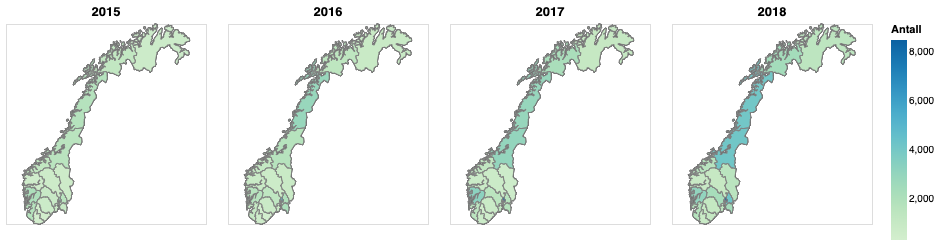

In [20]:
fig = map_2015 | map_2016 | map_2017 | map_2018
fig

In [21]:
description = '''
Estimert mangel på arbeidskraft i 2015-2018. Antall personer 
'''

dp.add_view(
    spec_type='vega',
    name='2015-2018',
    description = description,
    resources=[],
    attribution = "Kilde: NAV Bedriftsundersøkelsen",
    spec=fig.to_json()
)

# Hover tooltip

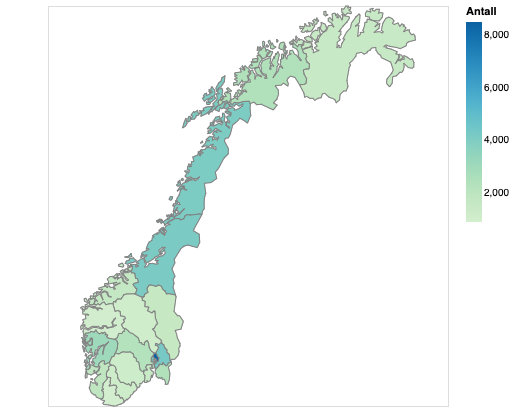

In [22]:
base_layer = alt.Chart(no_data).mark_geoshape(
    stroke='silver',
    strokeWidth=1
).encode(
).properties(
    width=400,
    height=400
)

hover = alt.selection(type='single', on='mouseover', nearest=True,
                      fields=['properties.lon', 'properties.lat'])

choro = alt.Chart(no_data).mark_geoshape(
        stroke='gray'
    ).encode(
        alt.Color('properties.2018', 
                  type='quantitative', 
                  scale=alt.Scale(scheme='greenblue'),
                  title = "Antall")
    ).add_selection(hover)

values = alt.Chart(no_data).encode(
    longitude='properties.lon:Q',
    latitude='properties.lat:Q',
)

text = values.mark_text(dx=-10, align='right').encode(
    alt.Text('properties.tooltip:N'),
    opacity=alt.condition(~hover, alt.value(0), alt.value(1))
)

fig = base_layer + choro + text
fig

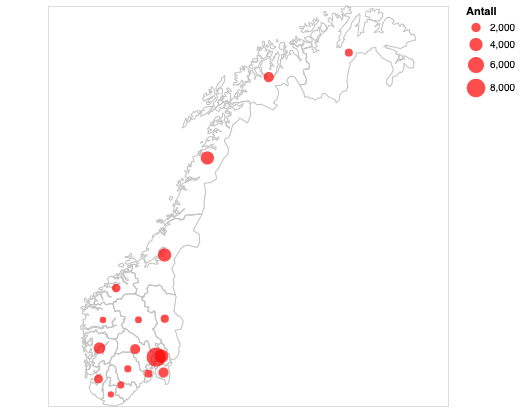

In [23]:
points = values.mark_point().encode(
    color=alt.value('black'),
    size=alt.condition(~hover, alt.value(30), alt.value(100))
).add_selection(hover)

points = values.mark_point().encode(
    alt.Size('properties.2018:Q',
    title = 'Antall'),
    color=alt.value('gray'),
    fill=alt.value('red')
).add_selection(hover)

fig = base_layer + points + text 
fig

In [24]:
description = '''
I NAVs bedriftsundersøkelse har vi også undersøkt hvilke rekrutteringskanaler virksomhetene benytter. Vi ser blant annet på hvor mange stillinger som lyses ut offentlig som sier noe om hvor transparent det norske arbeidsmarkedet er. [les mer på nav.no](https://www.nav.no/no/NAV+og+samfunn/Kunnskap/Analyser+fra+NAV/Arbeid+og+velferd/Arbeid+og+velferd/bedriftsunders%C3%B8kelsen)
'''

dp.add_view(
    spec_type='vega',
    name='2018',
    description = description,
    resources=[],
    attribution = "Kilde: NAV Bedriftsundersøkelsen",
    spec=fig.to_json()
)

In [25]:
client = dv.Client()
client.publish(dp)

2019-09-04T10:49:13.812772: B149899 <class 'dataverk.connectors.google_storage.GoogleStorageConnector'>: String (format: json) written to https://storage.googleapis.com/nav-opendata/0f59aef2db6c449d2cf76214c8982f4e/datapackage.json
2019-09-04T10:49:14.207905: B149899 <class 'dataverk.connectors.elasticsearch.ElasticsearchConnector'>: Document 0f59aef2db6c449d2cf76214c8982f4e of type {'id': '0f59aef2db6c449d2cf76214c8982f4e', 'type': 'datakatalog', 'suggest': 'Bedriftsundersøkelsen: Kartvisning Bedriftsundersøkelsen: Kartvisning', 'description': 'Bedriftsundersøkelsen: Kartvisning', 'title': 'Bedriftsundersøkelsen: Kartvisning', 'format': 'datapackage', 'category': 'Åpne data', 'provenance': 'NAV', 'master': 'NAV', 'purpose': ['Åpne data'], 'legalbasis': ['Åpne data'], 'pii': 'Åpne data', 'issued': '2019-09-04T10:49:13.820630', 'modified': '2019-09-04T10:49:13.820637', 'modified_by': '', 'created': '2019-09-04T10:49:13.820639', 'updated': '2019-09-04', 'created_by': 'paul.bencze@nav.no'